### 準備

In [ ]:
import torch
from tqdm import tqdm
from stable_baselines3 import PPO, SAC

from stable_baselines3.common.callbacks import EvalCallback

import os
import sys
sys.path.append(os.path.pardir)

from cpm_torch.CPM_Image import *
from cpm_torch.CPM import *
from cpm_torch.CPMEnv import *
from cpm_torch.Training.CPM_PPO import *
from cpm_torch.Training.CPM_Policy import *
from cpm_torch.Training.CPM_SAC_Policy import *

In [4]:
from datetime import datetime

def create_timestamped_results_dir(base_dir="results/PPOs"):
    """
    Creates a timestamped directory within the base results directory.
    
    Args:
        base_dir (str): Base directory where the timestamped folder will be created
        
    Returns:
        str: Path to the created directory
    """
    # Create the base directory if it doesn't exist
    if not os.path.exists(base_dir):
        os.makedirs(base_dir)
    
    # Create a timestamp string
    timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    
    # Create the full path
    result_dir = os.path.join(base_dir, timestamp)
    
    # Create the directory
    os.makedirs(result_dir)
    
    print(f"Created results directory: {result_dir}")
    return result_dir


is_continue = False  # Set to True if you want to continue training from a previous model

if is_continue:
    result_dir = "results/PPOs/20250513-041642"  # Example directory for demonstration
    model_dir = os.path.join(result_dir, "recent_model")
else:
    result_dir = create_timestamped_results_dir()

Created results directory: results/PPOs/20250524-205804


### ハイパーパラメータ

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPUを利用します: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("CPUを利用します")

config = CPM_config(
    size=(64, 64),  # 画像サイズ
    l_A=1.0,  # 面積エネルギー項の係数λ_A
    l_L=1.0,  # 周囲長エネルギー項の係数λ_L
    A_0=75.0,  # 目標細胞面積 A_0
    L_0=40.0,  # 目標細胞周囲長 L_0
    T=1.0,  # 温度パラメータ T
)
print(config.__dict__)

GPUを利用します: NVIDIA H100 PCIe
{'size': (64, 64), 'dim': 2, 'height': 64, 'width': 64, 'depth': 1, 'l_A': 1.0, 'l_L': 1.0, 'A_0': 75.0, 'L_0': 40.0, 'T': 1.0}


### 環境

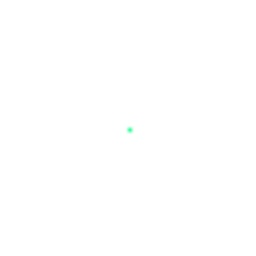

In [6]:
env = CPMEnv(config)  # CPM環境のインスタンスを作成
env.reset()  # 環境をリセット
env.render()  # 環境を描画

In [7]:
eval_freq = 10000
best_model_save_path = os.path.join(result_dir, "best_model")
n_eval_episodes = 10

eval_callback = EvalCallback(
    env,    # 評価環境
    log_path='path/to/log',
    eval_freq=eval_freq,
    deterministic=True,
    render=True,
    best_model_save_path=best_model_save_path,
    n_eval_episodes=n_eval_episodes
)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Number of parameters: 38740912
actor.latent_pi.fc1.weight: torch.Size([256, 9])
actor.latent_pi.fc1.bias: torch.Size([256])
actor.latent_pi.fc2.weight: torch.Size([256, 256])
actor.latent_pi.fc2.bias: torch.Size([256])
actor.latent_pi.fc3.weight: torch.Size([128, 256])
actor.latent_pi.fc3.bias: torch.Size([128])
actor.latent_pi.fc_mean.weight: torch.Size([4, 128])
actor.latent_pi.fc_mean.bias: torch.Size([4])
actor.latent_pi.fc_log_std.weight: torch.Size([4, 128])
actor.latent_pi.fc_log_std.bias: torch.Size([4])
actor.mu.weight: torch.Size([1936, 256])
actor.mu.bias: torch.Size([1936])
actor.log_std.weight: torch.Size([1936, 256])
actor.log_std.bias: torch.Size([1936])
critic.qf0.u_net1.downs.0.double_conv.0.weight: torch.Size([64, 1, 3, 3])
critic.qf0.u_net1.downs.0.double_conv.0.bias: torch.Size([64])
critic.qf0.u_net1.downs.0.double_conv.1.weight: torch.Size([64])
critic.qf0.u_net1.downs.0

/root/.pyenv/versions/3.9.17/lib/python3.9/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 201       |
|    ep_rew_mean     | 5.32      |
| time/              |           |
|    episodes        | 4         |
|    fps             | 3         |
|    time_elapsed    | 206       |
|    total_timesteps | 804       |
| train/             |           |
|    actor_loss      | -2.81e+03 |
|    critic_loss     | 2.1e+03   |
|    ent_coef        | 0.81      |
|    ent_coef_loss   | -686      |
|    learning_rate   | 0.0003    |
|    n_updates       | 703       |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 201       |
|    ep_rew_mean     | 5.1       |
| time/              |           |
|    episodes        | 8         |
|    fps             | 3         |
|    time_elapsed    | 437       |
|    total_timesteps | 1608      |
| train/             |           |
|    actor_loss      | -2.33e+03 |
|    critic_loss    

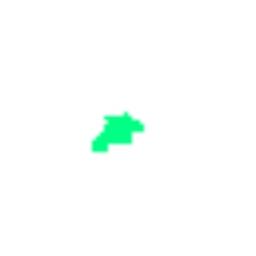

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 201       |
|    ep_rew_mean     | 4.99      |
| time/              |           |
|    episodes        | 32        |
|    fps             | 3         |
|    time_elapsed    | 1829      |
|    total_timesteps | 6432      |
| train/             |           |
|    actor_loss      | -732      |
|    critic_loss     | 589       |
|    ent_coef        | 0.151     |
|    ent_coef_loss   | -6.11e+03 |
|    learning_rate   | 0.0003    |
|    n_updates       | 6331      |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 201       |
|    ep_rew_mean     | 5.01      |
| time/              |           |
|    episodes        | 36        |
|    fps             | 3         |
|    time_elapsed    | 2061      |
|    total_timesteps | 7236      |
| train/             |           |
|    actor_loss      | -1.37e+03 |
|    critic_loss    

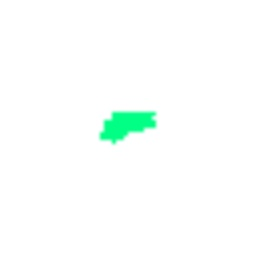

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 201       |
|    ep_rew_mean     | 5.09      |
| time/              |           |
|    episodes        | 60        |
|    fps             | 3         |
|    time_elapsed    | 3456      |
|    total_timesteps | 12060     |
| train/             |           |
|    actor_loss      | -446      |
|    critic_loss     | 68.1      |
|    ent_coef        | 0.0279    |
|    ent_coef_loss   | -1.14e+04 |
|    learning_rate   | 0.0003    |
|    n_updates       | 11959     |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 201       |
|    ep_rew_mean     | 5.11      |
| time/              |           |
|    episodes        | 64        |
|    fps             | 3         |
|    time_elapsed    | 3689      |
|    total_timesteps | 12864     |
| train/             |           |
|    actor_loss      | -507      |
|    critic_loss    

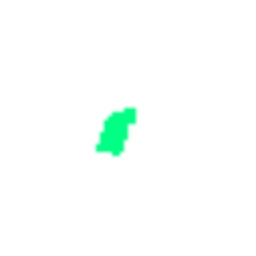

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 201       |
|    ep_rew_mean     | 5.15      |
| time/              |           |
|    episodes        | 92        |
|    fps             | 3         |
|    time_elapsed    | 5321      |
|    total_timesteps | 18492     |
| train/             |           |
|    actor_loss      | -102      |
|    critic_loss     | 2.66      |
|    ent_coef        | 0.00403   |
|    ent_coef_loss   | -1.78e+04 |
|    learning_rate   | 0.0003    |
|    n_updates       | 18391     |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 201       |
|    ep_rew_mean     | 5.14      |
| time/              |           |
|    episodes        | 96        |
|    fps             | 3         |
|    time_elapsed    | 5555      |
|    total_timesteps | 19296     |
| train/             |           |
|    actor_loss      | -93.1     |
|    critic_loss    

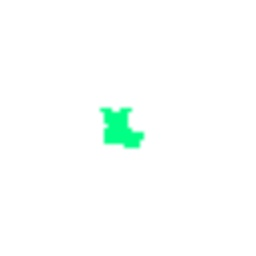

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 201      |
|    ep_rew_mean     | 5.17     |
| time/              |          |
|    episodes        | 120      |
|    fps             | 3        |
|    time_elapsed    | 6957     |
|    total_timesteps | 24120    |
| train/             |          |
|    actor_loss      | -46.1    |
|    critic_loss     | 0.615    |
|    ent_coef        | 0.000751 |
|    ent_coef_loss   | -2.2e+04 |
|    learning_rate   | 0.0003   |
|    n_updates       | 24019    |
---------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 201       |
|    ep_rew_mean     | 5.17      |
| time/              |           |
|    episodes        | 124       |
|    fps             | 3         |
|    time_elapsed    | 7190      |
|    total_timesteps | 24924     |
| train/             |           |
|    actor_loss      | -12.7     |
|    critic_loss     | 1.98      |
| 

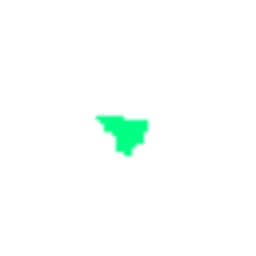

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 201       |
|    ep_rew_mean     | 5.18      |
| time/              |           |
|    episodes        | 152       |
|    fps             | 3         |
|    time_elapsed    | 8826      |
|    total_timesteps | 30552     |
| train/             |           |
|    actor_loss      | -13.9     |
|    critic_loss     | 0.0354    |
|    ent_coef        | 0.000109  |
|    ent_coef_loss   | -2.86e+04 |
|    learning_rate   | 0.0003    |
|    n_updates       | 30451     |
----------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 201      |
|    ep_rew_mean     | 5.19     |
| time/              |          |
|    episodes        | 156      |
|    fps             | 3        |
|    time_elapsed    | 9060     |
|    total_timesteps | 31356    |
| train/             |          |
|    actor_loss      | -13.4    |
|    critic_loss     | 0.0273  

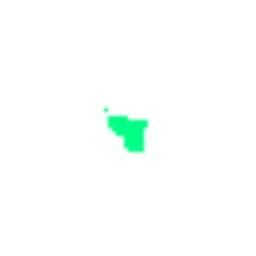

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 201       |
|    ep_rew_mean     | 5.13      |
| time/              |           |
|    episodes        | 180       |
|    fps             | 3         |
|    time_elapsed    | 10463     |
|    total_timesteps | 36180     |
| train/             |           |
|    actor_loss      | -3.83     |
|    critic_loss     | 0.0154    |
|    ent_coef        | 2.12e-05  |
|    ent_coef_loss   | -2.98e+04 |
|    learning_rate   | 0.0003    |
|    n_updates       | 36079     |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 201       |
|    ep_rew_mean     | 5.09      |
| time/              |           |
|    episodes        | 184       |
|    fps             | 3         |
|    time_elapsed    | 10697     |
|    total_timesteps | 36984     |
| train/             |           |
|    actor_loss      | -3.7      |
|    critic_loss    

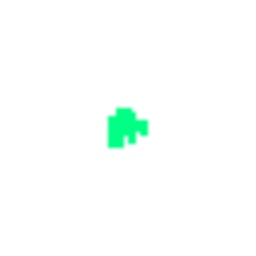

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 201       |
|    ep_rew_mean     | 5.1       |
| time/              |           |
|    episodes        | 212       |
|    fps             | 3         |
|    time_elapsed    | 12335     |
|    total_timesteps | 42612     |
| train/             |           |
|    actor_loss      | -2.36     |
|    critic_loss     | 0.00329   |
|    ent_coef        | 3.17e-06  |
|    ent_coef_loss   | -3.02e+04 |
|    learning_rate   | 0.0003    |
|    n_updates       | 42511     |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 201       |
|    ep_rew_mean     | 5.09      |
| time/              |           |
|    episodes        | 216       |
|    fps             | 3         |
|    time_elapsed    | 12569     |
|    total_timesteps | 43416     |
| train/             |           |
|    actor_loss      | -2        |
|    critic_loss    

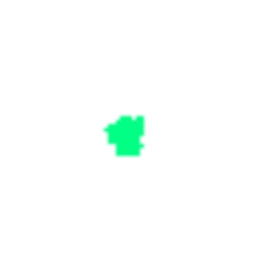

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 201       |
|    ep_rew_mean     | 5.05      |
| time/              |           |
|    episodes        | 240       |
|    fps             | 3         |
|    time_elapsed    | 13972     |
|    total_timesteps | 48240     |
| train/             |           |
|    actor_loss      | -1.55     |
|    critic_loss     | 0.000665  |
|    ent_coef        | 6.34e-07  |
|    ent_coef_loss   | -2.44e+04 |
|    learning_rate   | 0.0003    |
|    n_updates       | 48139     |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 201       |
|    ep_rew_mean     | 5.05      |
| time/              |           |
|    episodes        | 244       |
|    fps             | 3         |
|    time_elapsed    | 14206     |
|    total_timesteps | 49044     |
| train/             |           |
|    actor_loss      | -1.37     |
|    critic_loss    

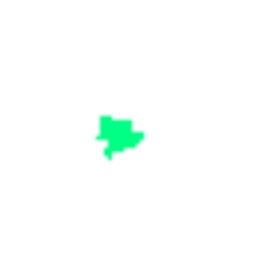

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 201       |
|    ep_rew_mean     | 5.01      |
| time/              |           |
|    episodes        | 272       |
|    fps             | 3         |
|    time_elapsed    | 15842     |
|    total_timesteps | 54672     |
| train/             |           |
|    actor_loss      | -0.94     |
|    critic_loss     | 0.000251  |
|    ent_coef        | 2.86e-07  |
|    ent_coef_loss   | -3.84e+04 |
|    learning_rate   | 0.0003    |
|    n_updates       | 54571     |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 201       |
|    ep_rew_mean     | 5.02      |
| time/              |           |
|    episodes        | 276       |
|    fps             | 3         |
|    time_elapsed    | 16075     |
|    total_timesteps | 55476     |
| train/             |           |
|    actor_loss      | -1.03     |
|    critic_loss    

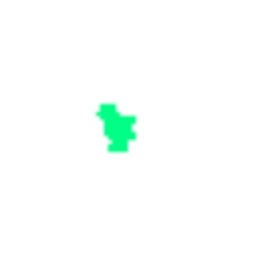

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 201      |
|    ep_rew_mean     | 5.03     |
| time/              |          |
|    episodes        | 300      |
|    fps             | 3        |
|    time_elapsed    | 17477    |
|    total_timesteps | 60300    |
| train/             |          |
|    actor_loss      | -0.932   |
|    critic_loss     | 0.000378 |
|    ent_coef        | 2.45e-07 |
|    ent_coef_loss   | 4.99e+03 |
|    learning_rate   | 0.0003   |
|    n_updates       | 60199    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 201      |
|    ep_rew_mean     | 5.04     |
| time/              |          |
|    episodes        | 304      |
|    fps             | 3        |
|    time_elapsed    | 17711    |
|    total_timesteps | 61104    |
| train/             |          |
|    actor_loss      | -1.02    |
|    critic_loss     | 0.00034  |
|    ent_coef 

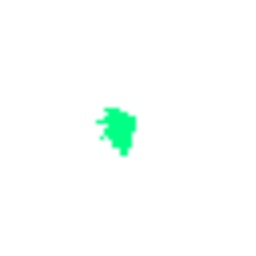

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 201      |
|    ep_rew_mean     | 5.08     |
| time/              |          |
|    episodes        | 332      |
|    fps             | 3        |
|    time_elapsed    | 19346    |
|    total_timesteps | 66732    |
| train/             |          |
|    actor_loss      | -0.796   |
|    critic_loss     | 0.000291 |
|    ent_coef        | 2.07e-07 |
|    ent_coef_loss   | 2e+04    |
|    learning_rate   | 0.0003   |
|    n_updates       | 66631    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 201      |
|    ep_rew_mean     | 5.08     |
| time/              |          |
|    episodes        | 336      |
|    fps             | 3        |
|    time_elapsed    | 19580    |
|    total_timesteps | 67536    |
| train/             |          |
|    actor_loss      | -0.849   |
|    critic_loss     | 0.000378 |
|    ent_coef 

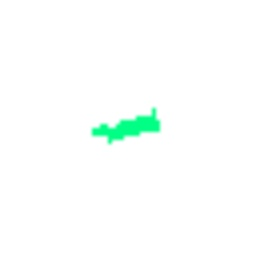

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 201       |
|    ep_rew_mean     | 5.09      |
| time/              |           |
|    episodes        | 360       |
|    fps             | 3         |
|    time_elapsed    | 20982     |
|    total_timesteps | 72360     |
| train/             |           |
|    actor_loss      | -0.721    |
|    critic_loss     | 0.000407  |
|    ent_coef        | 2.95e-07  |
|    ent_coef_loss   | -3.48e+04 |
|    learning_rate   | 0.0003    |
|    n_updates       | 72259     |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 201       |
|    ep_rew_mean     | 5.09      |
| time/              |           |
|    episodes        | 364       |
|    fps             | 3         |
|    time_elapsed    | 21215     |
|    total_timesteps | 73164     |
| train/             |           |
|    actor_loss      | -0.655    |
|    critic_loss    

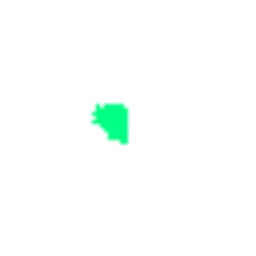

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 201       |
|    ep_rew_mean     | 5.01      |
| time/              |           |
|    episodes        | 392       |
|    fps             | 3         |
|    time_elapsed    | 22848     |
|    total_timesteps | 78792     |
| train/             |           |
|    actor_loss      | -0.685    |
|    critic_loss     | 0.000238  |
|    ent_coef        | 2.63e-07  |
|    ent_coef_loss   | -4.38e+03 |
|    learning_rate   | 0.0003    |
|    n_updates       | 78691     |
----------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 201      |
|    ep_rew_mean     | 5.02     |
| time/              |          |
|    episodes        | 396      |
|    fps             | 3        |
|    time_elapsed    | 23082    |
|    total_timesteps | 79596    |
| train/             |          |
|    actor_loss      | -0.626   |
|    critic_loss     | 0.000667

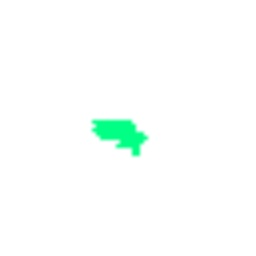

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 201       |
|    ep_rew_mean     | 4.93      |
| time/              |           |
|    episodes        | 420       |
|    fps             | 3         |
|    time_elapsed    | 24479     |
|    total_timesteps | 84420     |
| train/             |           |
|    actor_loss      | -0.791    |
|    critic_loss     | 0.000512  |
|    ent_coef        | 1.42e-07  |
|    ent_coef_loss   | -2.48e+04 |
|    learning_rate   | 0.0003    |
|    n_updates       | 84319     |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 201       |
|    ep_rew_mean     | 4.96      |
| time/              |           |
|    episodes        | 424       |
|    fps             | 3         |
|    time_elapsed    | 24712     |
|    total_timesteps | 85224     |
| train/             |           |
|    actor_loss      | -0.857    |
|    critic_loss    

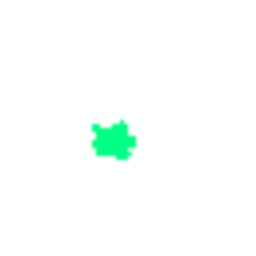

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 201      |
|    ep_rew_mean     | 4.96     |
| time/              |          |
|    episodes        | 452      |
|    fps             | 3        |
|    time_elapsed    | 26344    |
|    total_timesteps | 90852    |
| train/             |          |
|    actor_loss      | -0.582   |
|    critic_loss     | 0.000618 |
|    ent_coef        | 1.51e-07 |
|    ent_coef_loss   | 5.16e+03 |
|    learning_rate   | 0.0003   |
|    n_updates       | 90751    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 201      |
|    ep_rew_mean     | 4.95     |
| time/              |          |
|    episodes        | 456      |
|    fps             | 3        |
|    time_elapsed    | 26577    |
|    total_timesteps | 91656    |
| train/             |          |
|    actor_loss      | -0.645   |
|    critic_loss     | 0.000193 |
|    ent_coef 

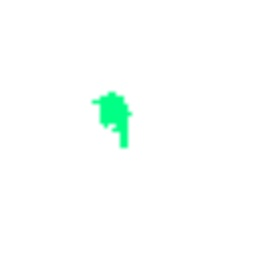

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 201      |
|    ep_rew_mean     | 4.96     |
| time/              |          |
|    episodes        | 480      |
|    fps             | 3        |
|    time_elapsed    | 28018    |
|    total_timesteps | 96480    |
| train/             |          |
|    actor_loss      | -0.472   |
|    critic_loss     | 0.000184 |
|    ent_coef        | 1.71e-07 |
|    ent_coef_loss   | 9.42e+03 |
|    learning_rate   | 0.0003   |
|    n_updates       | 96379    |
---------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 201       |
|    ep_rew_mean     | 4.97      |
| time/              |           |
|    episodes        | 484       |
|    fps             | 3         |
|    time_elapsed    | 28267     |
|    total_timesteps | 97284     |
| train/             |           |
|    actor_loss      | -0.467    |
|    critic_loss     | 0.000159  |
| 

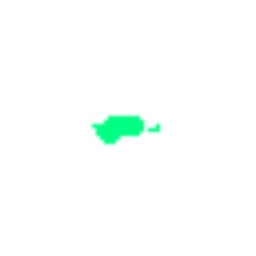

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 201       |
|    ep_rew_mean     | 4.92      |
| time/              |           |
|    episodes        | 512       |
|    fps             | 3         |
|    time_elapsed    | 29990     |
|    total_timesteps | 102912    |
| train/             |           |
|    actor_loss      | -0.496    |
|    critic_loss     | 0.000263  |
|    ent_coef        | 1.19e-07  |
|    ent_coef_loss   | -3.93e+03 |
|    learning_rate   | 0.0003    |
|    n_updates       | 102811    |
----------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 201      |
|    ep_rew_mean     | 4.93     |
| time/              |          |
|    episodes        | 516      |
|    fps             | 3        |
|    time_elapsed    | 30236    |
|    total_timesteps | 103716   |
| train/             |          |
|    actor_loss      | -0.308   |
|    critic_loss     | 0.00014 

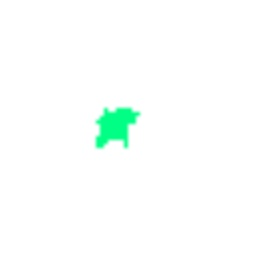

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 201      |
|    ep_rew_mean     | 4.95     |
| time/              |          |
|    episodes        | 540      |
|    fps             | 3        |
|    time_elapsed    | 31667    |
|    total_timesteps | 108540   |
| train/             |          |
|    actor_loss      | -0.663   |
|    critic_loss     | 0.00033  |
|    ent_coef        | 1.08e-07 |
|    ent_coef_loss   | 1.31e+04 |
|    learning_rate   | 0.0003   |
|    n_updates       | 108439   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 201      |
|    ep_rew_mean     | 4.92     |
| time/              |          |
|    episodes        | 544      |
|    fps             | 3        |
|    time_elapsed    | 31901    |
|    total_timesteps | 109344   |
| train/             |          |
|    actor_loss      | -0.761   |
|    critic_loss     | 0.000305 |
|    ent_coef 

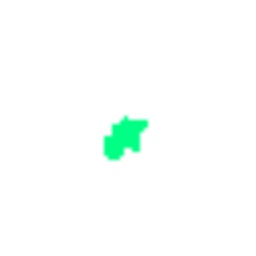

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 201      |
|    ep_rew_mean     | 4.98     |
| time/              |          |
|    episodes        | 572      |
|    fps             | 3        |
|    time_elapsed    | 33532    |
|    total_timesteps | 114972   |
| train/             |          |
|    actor_loss      | -0.659   |
|    critic_loss     | 0.000189 |
|    ent_coef        | 8.04e-08 |
|    ent_coef_loss   | 2.91e+04 |
|    learning_rate   | 0.0003   |
|    n_updates       | 114871   |
---------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 201       |
|    ep_rew_mean     | 4.98      |
| time/              |           |
|    episodes        | 576       |
|    fps             | 3         |
|    time_elapsed    | 33765     |
|    total_timesteps | 115776    |
| train/             |           |
|    actor_loss      | -0.738    |
|    critic_loss     | 0.000243  |
| 

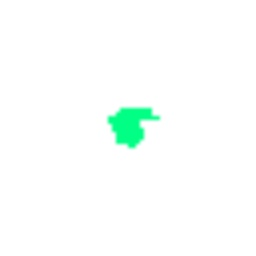

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 201      |
|    ep_rew_mean     | 5.04     |
| time/              |          |
|    episodes        | 600      |
|    fps             | 3        |
|    time_elapsed    | 35172    |
|    total_timesteps | 120600   |
| train/             |          |
|    actor_loss      | -0.429   |
|    critic_loss     | 0.000102 |
|    ent_coef        | 6.18e-08 |
|    ent_coef_loss   | 2.55e+04 |
|    learning_rate   | 0.0003   |
|    n_updates       | 120499   |
---------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 201       |
|    ep_rew_mean     | 5.04      |
| time/              |           |
|    episodes        | 604       |
|    fps             | 3         |
|    time_elapsed    | 35406     |
|    total_timesteps | 121404    |
| train/             |           |
|    actor_loss      | -0.434    |
|    critic_loss     | 0.000119  |
| 

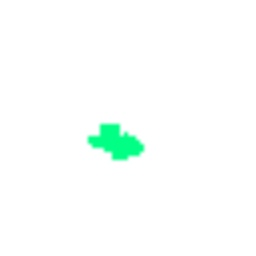

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 201      |
|    ep_rew_mean     | 5.06     |
| time/              |          |
|    episodes        | 632      |
|    fps             | 3        |
|    time_elapsed    | 37044    |
|    total_timesteps | 127032   |
| train/             |          |
|    actor_loss      | -0.562   |
|    critic_loss     | 0.000272 |
|    ent_coef        | 5.2e-08  |
|    ent_coef_loss   | 1.04e+04 |
|    learning_rate   | 0.0003   |
|    n_updates       | 126931   |
---------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 201       |
|    ep_rew_mean     | 5.04      |
| time/              |           |
|    episodes        | 636       |
|    fps             | 3         |
|    time_elapsed    | 37278     |
|    total_timesteps | 127836    |
| train/             |           |
|    actor_loss      | -0.576    |
|    critic_loss     | 0.000175  |
| 

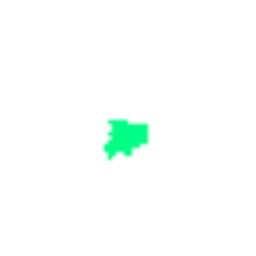

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 201      |
|    ep_rew_mean     | 5.03     |
| time/              |          |
|    episodes        | 660      |
|    fps             | 3        |
|    time_elapsed    | 38680    |
|    total_timesteps | 132660   |
| train/             |          |
|    actor_loss      | -0.62    |
|    critic_loss     | 0.000261 |
|    ent_coef        | 8.99e-08 |
|    ent_coef_loss   | -524     |
|    learning_rate   | 0.0003   |
|    n_updates       | 132559   |
---------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 201       |
|    ep_rew_mean     | 5.01      |
| time/              |           |
|    episodes        | 664       |
|    fps             | 3         |
|    time_elapsed    | 38914     |
|    total_timesteps | 133464    |
| train/             |           |
|    actor_loss      | -0.621    |
|    critic_loss     | 0.000182  |
| 

KeyboardInterrupt: 

In [8]:
model = SAC(CPM_SAC_Policy, env, tensorboard_log=os.path.join(result_dir), verbose=1 )#batch_size=64)
# パラメータ数を表示
print(f"Number of parameters: {sum(p.numel() for p in model.policy.parameters())}")
for name, param in model.policy.named_parameters():
    print(f"{name}: {param.size()}")
print(model.policy)
model.learn(total_timesteps=1000000, progress_bar=True)  # 学習を実行